# Project 3

## 1. Data Preparation

### Import the Data

The data we are using is bulk data for individual Magic the Gathering cards throughout history. To access this data, we have locally downloaded a bulk data file in json formatting from `https://scryfall.com/docs/api/bulk-data`. The particular dataset we will be using is the `Oracle Cards` dataset, which contains the latest version of each card, thus preventing duplicate cards. Furthermore, this data is conveniently stored in a JSON file, and uncompressed only amounts to `126 MB`.

In [ ]:
import json

# Open and read local json
path = 'oracle-cards-20231009090140.json'
with open(path, 'r') as json_file:
    data = json.load(json_file)

FileNotFoundError: ignored

### Store and Clean the Data

Let's clean the data a bit to make our lives easier. To do so we will remove the following cards:
* **Non-normal layouts:** this includes cards like adventures and double-faced cards, which are essentially two cards in one. These may skew the data, so we will ignore them.
* **Universes Beyond cards:** these are collaborative cards with other IPs (e.g. Warhammer, Lord of the Rings). These cards often add mechanics with unique keywords for cards.
* **Un-sets:** these are joke sets and often have very wacky mechanics.
* **Online sets:** these are sets that are only available online, and often feature inpracticle mechanics.
* **Tokens:** these are game pieces that are introduced through other cards, and are not playable on their own.

In [ ]:
# Specify the sets to be removed
specified_sets = ["40k", "who", "clb", "afr", "fj22", "fltr"]
specified_set_type = ["funny", "memorabilia"]

# Filter out cards from the data
data = [
    card_data for card_data in data
    if 'normal' in card_data.get('layout', [])                   # remove problematic layouts
    and 'paper' in card_data.get('games', [])                    # remove non-paper cards (ie. online cards)
    and card_data.get('layout', '') != 'token'                   # remove tokens
    and card_data.get('set', '') not in specified_sets           # remove problematic sets
    and card_data.get('set_type', '') not in specified_set_type  # remove problematic set types
]

The data can now be stored by simply iterating over each card and storing the desired values.

In [ ]:
# Initialize lists for ordered and possibly duplicated characteristics
card_list = []
all_oracle_text = []
all_cmc = []
all_card_types = []

# Initialize sets for unordered and not duplicatable characteristics
unique_cmc = set()
unique_card_types = set()

# Iterate through the JSON data to extract card information and collect unique set names, keywords, and oracle text
for card_data in data:
    card_info = {
        'name': card_data.get('name', ''),                          # debugging
        'oracle_text': card_data.get('oracle_text', ''),            # extact each card's oracle text
        'cmc': card_data.get('cmc', 0),                             # extract the converted mana value as a float
        'type': card_data.get('type_line', []).split(" — ")[0],     # extract the main card type
    }

    # Update lists and sets
    all_oracle_text.append(card_info['oracle_text'])
    unique_cmc.update([card_info['cmc']])
    all_cmc.append([card_info['cmc']])
    unique_card_types.update([card_info['type']])
    all_card_types.append([card_info['type']])

    # Update the card information list
    card_list.append(card_info)

Next, lets make sure to remove all new line characters `\\n` from the `oracle_text`.

In [ ]:
# Iterate through card_list and replace '\n' with a space in oracle_text
for card_info in card_list:
    card_info['oracle_text'] = card_info['oracle_text'].replace('\n', ' ')

Another problem we may encounter is if there are multiple card types for a single card, such as `Legendary Creature`.

In [ ]:
print(unique_card_types)

{'Creature', 'Legendary Creature', 'Snow Artifact', 'Legendary Artifact Creature', 'Enchantment Creature', 'Tribal Artifact', 'Legendary Enchantment Artifact', 'Legendary Planeswalker', 'Legendary Snow Enchantment', 'Snow Land', 'Legendary Artifact', 'Legendary Snow Creature', 'Dungeon', 'Tribal Sorcery', 'Artifact', 'Snow Enchantment', 'Tribal Instant', 'Legendary Sorcery', 'Legendary Instant', 'Artifact Land', 'Instant', 'Snow Sorcery', 'Legendary Enchantment', 'Conspiracy', 'Legendary Snow Land', 'Snow Creature', 'Legendary Land', 'Token Artifact Creature', 'Card', 'Sorcery', 'Snow Instant', 'Artifact Creature', 'Basic Snow Land', 'Land', 'Snow Artifact Creature', 'Enchantment', 'Basic Land', 'Land Creature', 'Legendary Enchantment Creature', 'Tribal Enchantment', 'World Enchantment'}


We can make our lives easier by just keeping the last listed card type, which is typically the primary card type. For example, `Legendary Creature` would just be `Creature`.

In [ ]:
# Declare a new set to stored unique card types for debugging
modified_card_types = set()

# Iterate through card_list and only keep the last type
for card_info in card_list:
    card_info['type'] = card_info['type'].split(' ')[-1]
    modified_card_types.update([card_info['type']])

# Print the modified list of unique card types
print(modified_card_types)

{'Creature', 'Planeswalker', 'Land', 'Dungeon', 'Artifact', 'Enchantment', 'Instant', 'Card', 'Sorcery', 'Conspiracy'}


Let's print a random card as a test.

In [ ]:
import random

# Generate a random index within the range of card_list
random_index = random.randint(0, len(card_list) - 1)

# Retrieve the card information using the random index
random_card = card_list[random_index]

# Print information about the random card
print("Random Card Information:")
print("Name:", random_card['name'])
print("CMC:", random_card['cmc'])
print("Type:", random_card['type'])
print("Oracle Text:", random_card['oracle_text'])

Random Card Information:
Name: Vivien's Arkbow
CMC: 2.0
Type: Artifact
Oracle Text: {X}, {T}, Discard a card: Look at the top X cards of your library. You may put a creature card with mana value X or less from among them onto the battlefield. Put the rest on the bottom of your library in a random order.


### Encoding and Splitting

Before we feed our data into our neural network, we need to ensure the data is properly encoded. The `oracle_text` data will be tokenized in the model architecture, so we can ignore it for now. On the other hand, `type` needs to be one-hot encoded, which can be done with `LabelEncoder` given that each card has a unique label. We also need to declare the features and target values of our data, which will be the `oracle_text` and encoded `type` respectively.

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Declare feature and target arrays
X = []
Y = []

# Store target and features
for card_info in card_list:
    X.append(card_info['oracle_text'])
    Y.append(card_info['type'])

# Initialize LabelEncoder and fit the labels
encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y)

# Convert lists to arrays
X = np.array(X)
Y = Y_encoded

Then we want to split our data using `train_test_split` into a 50|50 split.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.5, random_state=1)

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(11381,)
(11381,)
(11381,)
(11381,)


### Vectorization

Vectorization can be done using `TextVectorization`, in which the inputed string is converted into tokens, which are then fit to the text dataset.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# max_tokens most common words (i.e. the vocabulary) are selected.
vectorizeLayer.adapt(trainX)

## 2. Benchmarking

For our benchmarking, we'll be using logistic regression. This first requires that we vectorize our data. However, the previously used `TextVectorization` is not applicable here, so we have to use `TfidVectorizer` instead.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=maxTokens)

# Fit and transform the training data
trainX_tfidf = tfidf_vectorizer.fit_transform(trainX)
testX_tfidf = tfidf_vectorizer.transform(testX)

# Initialize and fit a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(trainX_tfidf, trainY)

# Predict on the test set
predictions = logistic_model.predict(testX_tfidf)

# Calculate accuracy
accuracy = accuracy_score(testY, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(testY, predictions))

Accuracy: 0.7624
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.37      0.51       806
           1       0.00      0.00      0.00         3
           2       1.00      0.62      0.76        13
           3       0.80      0.94      0.87      6155
           4       0.00      0.00      0.00         2
           5       0.82      0.56      0.66      1200
           6       0.66      0.61      0.63      1445
           7       0.76      0.59      0.67       361
           8       0.90      0.23      0.36       115
           9       0.59      0.61      0.60      1281

    accuracy                           0.76     11381
   macro avg       0.64      0.45      0.51     11381
weighted avg       0.76      0.76      0.75     11381



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3. Training and Tuning

### Base Model

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
num_classes = len(encoder.classes_)
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 128)          128128    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

Epoch 1/10
356/356 [==============================] - 22s 36ms/step - loss: 1.5537 - accuracy: 0.5387 - val_loss: 1.4386 - val_accuracy: 0.5410
Epoch 2/10
356/356 [==============================] - 7s 20ms/step - loss: 1.4727 - accuracy: 0.5465 - val_loss: 1.4374 - val_accuracy: 0.5408
Epoch 3/10
356/356 [==============================] - 6s 16ms/step - loss: 1.4523 - accuracy: 0.5471 - val_loss: 1.4326 - val_accuracy: 0.5408
Epoch 4/10
356/356 [==============================] - 7s 21ms/step - loss: 1.4450 - accuracy: 0.5475 - val_loss: 1.4289 - val_accuracy: 0.5408
Epoch 5/10
356/356 [==============================] - 6s 17ms/step - loss: 1.4438 - accuracy: 0.5475 - val_loss: 1.4382 - val_accuracy: 0.5408
Epoch 6/10
356/356 [==============================] - 5s 14ms/step - loss: 1.4429 - accuracy: 0.5475 - val_loss: 1.4364 - val_accuracy: 0.5408
Epoch 7/10
356/356 [==============================] - 6s 17ms/step - loss: 1.4390 - accuracy: 0.5475 - val_loss: 1.4332 - val_accuracy: 0.540

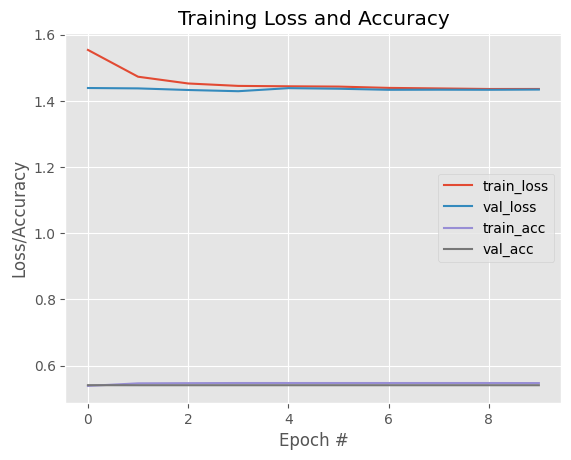

In [ ]:
import matplotlib.pyplot as plt

epochs = 10

H = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')

# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [ ]:
model.evaluate(testX, testY)

356/356 [==============================] - 3s 9ms/step - loss: 1.4339 - accuracy: 0.5408


[1.4339475631713867, 0.5408136248588562]

The model seems pretty stagnat, but it's possible there simply aren't enough epochs to converge, so let's increase the number of epochs to 50.

### Additional Epochs

Epoch 1/50
356/356 [==============================] - 6s 16ms/step - loss: 1.4334 - accuracy: 0.5475 - val_loss: 1.4354 - val_accuracy: 0.5408
Epoch 2/50
356/356 [==============================] - 5s 15ms/step - loss: 1.4352 - accuracy: 0.5475 - val_loss: 1.4342 - val_accuracy: 0.5408
Epoch 3/50
356/356 [==============================] - 6s 16ms/step - loss: 1.4336 - accuracy: 0.5475 - val_loss: 1.4336 - val_accuracy: 0.5408
Epoch 4/50
356/356 [==============================] - 4s 12ms/step - loss: 1.4313 - accuracy: 0.5475 - val_loss: 1.4341 - val_accuracy: 0.5408
Epoch 5/50
356/356 [==============================] - 4s 11ms/step - loss: 1.4263 - accuracy: 0.5476 - val_loss: 1.4346 - val_accuracy: 0.5408
Epoch 6/50
356/356 [==============================] - 5s 15ms/step - loss: 1.4312 - accuracy: 0.5475 - val_loss: 1.4342 - val_accuracy: 0.5408
Epoch 7/50
356/356 [==============================] - 4s 12ms/step - loss: 1.4132 - accuracy: 0.5473 - val_loss: 1.4122 - val_accuracy: 0.5408

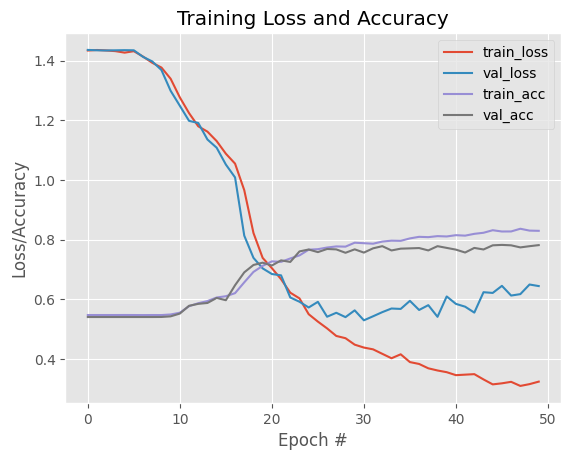

In [ ]:
import matplotlib.pyplot as plt

epochs = 50

H = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')

# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [ ]:
model.evaluate(testX, testY)

356/356 [==============================] - 2s 6ms/step - loss: 0.6445 - accuracy: 0.7817


[0.644487202167511, 0.781653642654419]

At this point we see the model starting to reach a more stable point, however, there is definitely some overfitting so let's add some dropout.

### Dropout

In [ ]:
model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64))
model.add(Dropout(0.5))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
num_classes = len(encoder.classes_)
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 100, 128)          128128    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

Epoch 1/50
356/356 [==============================] - 17s 38ms/step - loss: 1.5707 - accuracy: 0.5353 - val_loss: 1.4472 - val_accuracy: 0.5408
Epoch 2/50
356/356 [==============================] - 6s 16ms/step - loss: 1.4702 - accuracy: 0.5472 - val_loss: 1.4333 - val_accuracy: 0.5408
Epoch 3/50
356/356 [==============================] - 4s 13ms/step - loss: 1.4515 - accuracy: 0.5472 - val_loss: 1.4288 - val_accuracy: 0.5413
Epoch 4/50
356/356 [==============================] - 7s 19ms/step - loss: 1.4079 - accuracy: 0.5500 - val_loss: 1.3393 - val_accuracy: 0.5410
Epoch 5/50
356/356 [==============================] - 4s 13ms/step - loss: 1.3417 - accuracy: 0.5649 - val_loss: 1.2438 - val_accuracy: 0.5695
Epoch 6/50
356/356 [==============================] - 5s 15ms/step - loss: 1.2633 - accuracy: 0.5630 - val_loss: 1.2100 - val_accuracy: 0.5972
Epoch 7/50
356/356 [==============================] - 5s 15ms/step - loss: 1.2754 - accuracy: 0.6002 - val_loss: 1.2609 - val_accuracy: 0.614

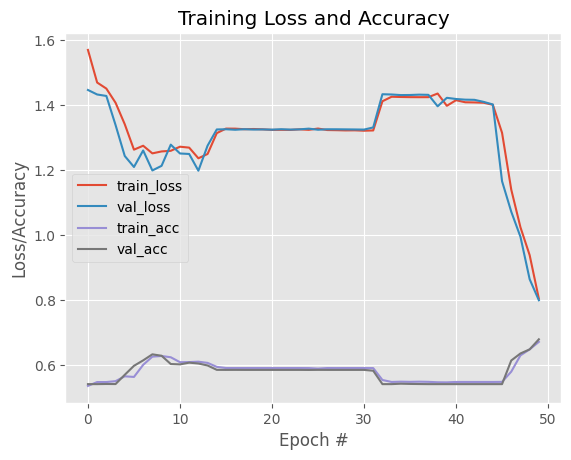

In [ ]:
import matplotlib.pyplot as plt

epochs = 50

H = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')

# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [ ]:
model.evaluate(testX, testY)

356/356 [==============================] - 3s 8ms/step - loss: 0.7993 - accuracy: 0.6789


[0.7993366122245789, 0.6789385676383972]

### Dropout epochs 100

In [ ]:
model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64))
model.add(Dropout(0.5))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
num_classes = len(encoder.classes_)
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding_8 (Embedding)     (None, 100, 128)          128128    
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                      

Epoch 1/100
356/356 [==============================] - 16s 39ms/step - loss: 1.5624 - accuracy: 0.5345 - val_loss: 1.4407 - val_accuracy: 0.5408
Epoch 2/100
356/356 [==============================] - 6s 17ms/step - loss: 1.4687 - accuracy: 0.5472 - val_loss: 1.4341 - val_accuracy: 0.5408
Epoch 3/100
356/356 [==============================] - 5s 14ms/step - loss: 1.4551 - accuracy: 0.5473 - val_loss: 1.4350 - val_accuracy: 0.5408
Epoch 4/100
356/356 [==============================] - 6s 16ms/step - loss: 1.4375 - accuracy: 0.5474 - val_loss: 1.4382 - val_accuracy: 0.5408
Epoch 5/100
356/356 [==============================] - 7s 19ms/step - loss: 1.4451 - accuracy: 0.5475 - val_loss: 1.4395 - val_accuracy: 0.5408
Epoch 6/100
356/356 [==============================] - 5s 15ms/step - loss: 1.4440 - accuracy: 0.5475 - val_loss: 1.4333 - val_accuracy: 0.5408
Epoch 7/100
356/356 [==============================] - 5s 14ms/step - loss: 1.4386 - accuracy: 0.5475 - val_loss: 1.4333 - val_accuracy

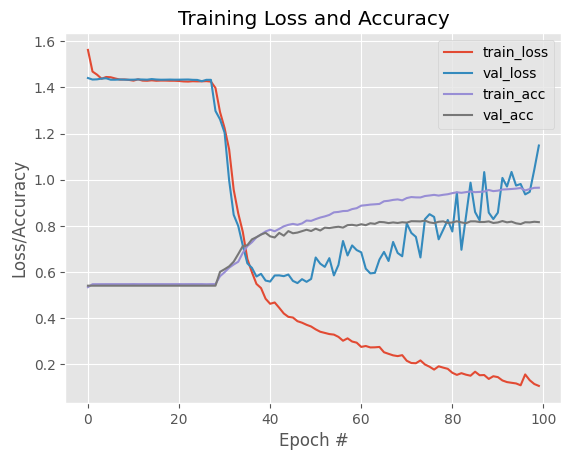

In [ ]:
import matplotlib.pyplot as plt

epochs = 100

H = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')

# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [ ]:
model.evaluate(testX, testY)

356/356 [==============================] - 2s 6ms/step - loss: 1.1482 - accuracy: 0.8162


[1.1481748819351196, 0.8161848783493042]

This might have helped with overfitting, but it's hard to tell since we haven't converged. Let's add more epochs while also adding early stopping.

### Early Stopping & 100 Epochs

In [ ]:
model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64))
model.add(Dropout(0.5))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
num_classes = len(encoder.classes_)
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding_10 (Embedding)    (None, 100, 128)          128128    
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                     

Epoch 1/100
356/356 [==============================] - 155s 39ms/step - loss: 1.5852 - accuracy: 0.5385 - val_loss: 1.4519 - val_accuracy: 0.5408
Epoch 2/100
356/356 [==============================] - 6s 17ms/step - loss: 1.4663 - accuracy: 0.5472 - val_loss: 1.4332 - val_accuracy: 0.5410
Epoch 3/100
356/356 [==============================] - 5s 15ms/step - loss: 1.4576 - accuracy: 0.5472 - val_loss: 1.4120 - val_accuracy: 0.5411
Epoch 4/100
356/356 [==============================] - 4s 12ms/step - loss: 1.4485 - accuracy: 0.5465 - val_loss: 1.4360 - val_accuracy: 0.5408
Epoch 5/100
356/356 [==============================] - 6s 16ms/step - loss: 1.4439 - accuracy: 0.5475 - val_loss: 1.4325 - val_accuracy: 0.5408
Epoch 6/100
356/356 [==============================] - 5s 14ms/step - loss: 1.4223 - accuracy: 0.5488 - val_loss: 1.3608 - val_accuracy: 0.5625
Epoch 7/100
356/356 [==============================] - 6s 17ms/step - loss: 1.3832 - accuracy: 0.5658 - val_loss: 1.3564 - val_accurac

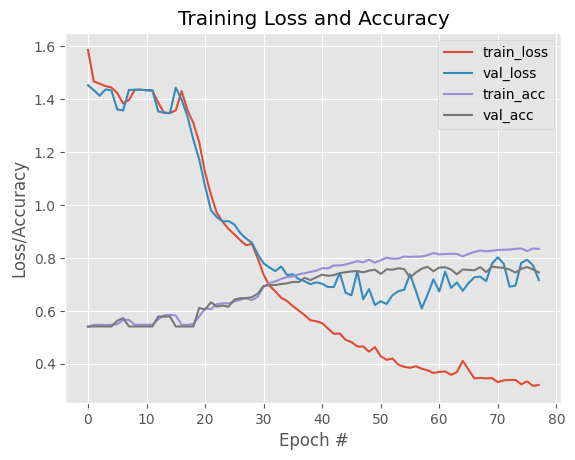

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

epochs = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=epochs, callbacks=[early_stopping])


plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, len(H.history['loss'])), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, len(H.history['val_loss'])), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, len(H.history['accuracy'])), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, len(H.history['val_accuracy'])), H.history['val_accuracy'], label = 'val_acc')

# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [ ]:
model.evaluate(testX, testY)

356/356 [==============================] - 3s 7ms/step - loss: 0.6086 - accuracy: 0.7592


[0.6086465716362, 0.759247899055481]

### Regularization

In [ ]:
from tensorflow.keras import regularizers

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64))
model.add(Dropout(0.5))

# add a dense layer
model.add(Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

# add softmax classifier
num_classes = len(encoder.classes_)
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding_13 (Embedding)    (None, 100, 128)          128128    
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                     

Epoch 1/100
356/356 [==============================] - 15s 35ms/step - loss: 1.7995 - accuracy: 0.5334 - val_loss: 1.5166 - val_accuracy: 0.5408
Epoch 2/100
356/356 [==============================] - 6s 18ms/step - loss: 1.5601 - accuracy: 0.5430 - val_loss: 1.4706 - val_accuracy: 0.5408
Epoch 3/100
356/356 [==============================] - 6s 17ms/step - loss: 1.4738 - accuracy: 0.5475 - val_loss: 1.4510 - val_accuracy: 0.5408
Epoch 4/100
356/356 [==============================] - 4s 12ms/step - loss: 1.4576 - accuracy: 0.5475 - val_loss: 1.4434 - val_accuracy: 0.5408
Epoch 5/100
356/356 [==============================] - 5s 15ms/step - loss: 1.4473 - accuracy: 0.5475 - val_loss: 1.4447 - val_accuracy: 0.5408
Epoch 6/100
356/356 [==============================] - 4s 11ms/step - loss: 1.4424 - accuracy: 0.5475 - val_loss: 1.4380 - val_accuracy: 0.5408
Epoch 7/100
356/356 [==============================] - 5s 14ms/step - loss: 1.4412 - accuracy: 0.5475 - val_loss: 1.4372 - val_accuracy

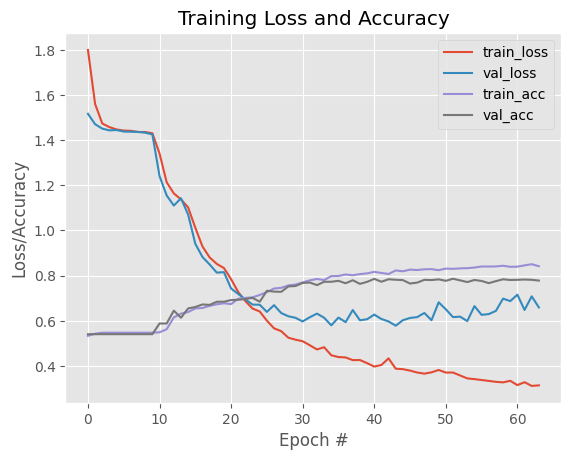

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

epochs = 100

#H = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=epochs, callbacks=[early_stopping])


plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, len(H.history['loss'])), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, len(H.history['val_loss'])), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, len(H.history['accuracy'])), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, len(H.history['val_accuracy'])), H.history['val_accuracy'], label = 'val_acc')

# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [ ]:
model.evaluate(testX, testY)

356/356 [==============================] - 2s 5ms/step - loss: 0.5783 - accuracy: 0.7818


[0.5783419013023376, 0.7818293571472168]

## 4. Conclusions

Improvements:
One of the major flaws is the fact that we simplified our data to have unique lables. For example an artifact creature was simply labeled as a creature. Further work could be done to add multiple labels to each card, which could then be encoded with binary labeling and compiled with categorical crossentropy loss function.